In [237]:
from PIL import Image
import numpy as np

import sklearn as sk
from sklearn import cluster
from sklearn import linear_model
from scipy.optimize import minimize

import itertools
import os
from itertools import cycle

import scipy.stats as stats
from scipy.misc import factorial

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import seaborn as sns

import cv2

%matplotlib inline

In [238]:
def load_image( infilename ) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [239]:
image_arr = load_image("snap_gray.png")

In [240]:
image_arr.shape

(216, 384, 2)

In [241]:
x_coord = []
y_coord = []
for i,row in enumerate(image_arr):
    for j, col in enumerate(row):
        if (col[0] > 0):
            x_coord.append(i)
            y_coord.append(j)
            
x_coord = np.array(x_coord)
y_coord = np.array(y_coord)

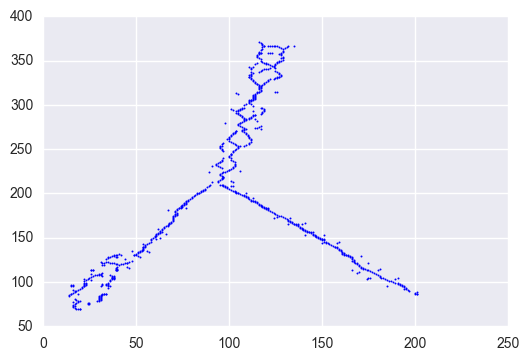

In [242]:
plt.scatter(x_coord, y_coord, lw=0, s=2)
plt.show()

## Expectation Maximisation Approach

In [243]:
# TODO:
# Note to Aditi, I have guessed at these from the full image with the session boundaries.
# Have you run code that picks up the correct coordinates and labels the biomes correctly?

biomes = [
    ("biome1", 10, 122),
    ("biome2", 5,  211),
    ("biome3", 30, 315),
    ("biome4", 192, 70),
    ("biome5", 198, 178),
    ("biome6", 160, 270),
    ("waterfall",110,325)
]

I am still iterating with how this code should work but we'll extract the following into a source file at some stage.

In [244]:
# helper functions
def f(yi, mui, sigma2, **kwargs):
    # here we have the normal density along the y_axis. This is not ideal
    # and should be updated to detect the density perpendicular to the detected line.
#     if 
    value = np.exp(-((yi-mui)**2)/(2*sigma2))/np.sqrt(2*np.pi*sigma2)
    return value

def T(j, i, params, **kwargs):
    terms = [params['tau'][k] * f(params['y'][i], params['X'][i].dot(params['mu'][k]), params['sigma2'][k]) for k in range(params['K'])]
    return terms[j]/np.sum(terms)

def T_tplus1(j, params, **kwargs):
    return params['denom'][j]/len(params['y'])

def U_tplus1(j, params, **kwargs):
    x = params['X']
    xt = params['X'].T
    w = params['T'][:,j].reshape(-1,1)
    y = params['y']
    weighted_num = np.linalg.pinv(xt.dot(w*x)).dot(xt*w.T).dot(y)
    return weighted_num

def Sigma_tplus1(j, params, **kwargs):
    weighted_num = np.sum([params['T'][i,j] * np.square(params['y'][i] - params['X'][i].dot(params['mu'][j])) for i in params['N']])
    denom = params['denom'][j]
    return weighted_num/denom

def default_stop(old_state, params):
    return params['count'] <= 20
    
class WaterPath:
    def __init__(self, X, y, biomes, **kwargs):
        self.X = X
        self.y = y
        self.biomes = biomes
        # array of centroids of the streams - This is probably the log coordinates
        self.centroid = kwargs['centroid'] if 'centroid' in kwargs else None;
        self.K = kwargs['K'] if 'K' in kwargs else 3; # number of distinct streams
        self.N = kwargs['N'] if 'N' in kwargs else range(len(y)); # number of datapoints
    
    def initialise_params(self, log_position, num_streams):
        # TODO: Some fancy stuff to init params here
        # Note to Aditi. EM is susceptible to bad initialisations (as it might get stuck at other optima). A good 
        # initialisation of the algorithm is going to be important. We can use the log positions and the fact that 
        # we know the waterfall is always running to assist with this.
        
        mu = np.array([[0,200],[5,-300],[-2,400]])
        tau = [0.33,0.34,0.33]
        sigma = [15,15,15]
        
        self.X = np.concatenate([self.X, np.array([[self.centroid[0], 1]])])
        self.y = np.concatenate([self.y, [self.centroid[1]]])
        
        params = {
            'tau' : tau,
            'mu' : mu,
            'sigma2' : sigma,
            'X' : self.X,
            'y' : self.y,
            'count': 0,
            'T': np.zeros_like(self.N),
            'K': self.K,
            'N': range(len(self.y)),
            'centroid': [100,100,100]
        }
        
        return params
    
    # Run EM algorithm
    def EM(self, params, stopping_condition=default_stop):
        
        old_state = None
        
        while stopping_condition(old_state, params):
            old_state = params
            
            params['T'] = np.array([[T(j,i,params) for j in range(self.K)] for i in params['N']])

            # clamp the algorithm to pass through the centroid
            params['T'][-1] = np.array([100,100,100])

            params['denom'] = np.sum(params['T'], axis=0)

            tp1 = [T_tplus1(j, params) for j in range(params['K'])]
            up1 = [U_tplus1(j, params) for j in range(params['K'])]

            params['mu'] = up1
            sp1 = [Sigma_tplus1(j, params) for j in range(params['K'])]

            params['tau'] = tp1
            params['sigma2'] = sp1
            params['count'] += 1
            
#             centroid = find_centroid(params)
            self.X[-1] = np.array([[self.centroid[0], 1]])
        return params
    
    def get_biomes_associated_with_params(self, params):
        
        y = np.array([biome[2] for biome in self.biomes])
        X = np.array([[biome[1],1] for biome in self.biomes])
        
        selected_biome = []
        for mu, sigma2 in zip(params['mu'], params['sigma2']):
        
            selected_biome.append(np.argmax([
                        f(y[i], X[i].dot(mu), sigma2) for i in range(len(y))]))
            
        return [self.biomes[i] for i in selected_biome]
    
    def print_waterflow(self, params):
        
        selected_biomes = self.get_biomes_associated_with_params(params)
        
        # start with the waterfall
        for i, (mu, sigma2) in enumerate(zip(params['mu'], params['sigma2'])):
            
            print(selected_biomes[i])
            print("Edge1: {}, Edge2: {}".format(self.centroid, [selected_biomes[i][1], selected_biomes[i][2]]))
            
            if selected_biomes[i][0] == 'waterfall':
                print("Incoming: True")
                print("Percentage flow: {}".format(params['tau'][i]*100))
                
            else:
                print("Incoming: False")
                print("Percentage of flow: {}".format(params['tau'][i]*100))
                
            print()
        

We can use the above class to detect the water paths.

In [245]:
X = np.concatenate([x_coord.reshape(-1,1), np.ones_like(x_coord.reshape(-1,1))], axis=1)
water_path = WaterPath(X, y_coord, biomes, centroid=[95,210])
params = water_path.initialise_params(None, None)
params = water_path.EM(params)

In [246]:
s_b = water_path.get_biomes_associated_with_params(params)
water_path.print_waterflow(params)

('biome1', 10, 122)
Edge1: [95, 210], Edge2: [10, 122]
Incoming: False
Percentage of flow: 50.542572488970116

('waterfall', 110, 325)
Edge1: [95, 210], Edge2: [110, 325]
Incoming: True
Percentage flow: 48.22837117539683

('biome4', 192, 70)
Edge1: [95, 210], Edge2: [192, 70]
Incoming: False
Percentage of flow: 39.3182283101554



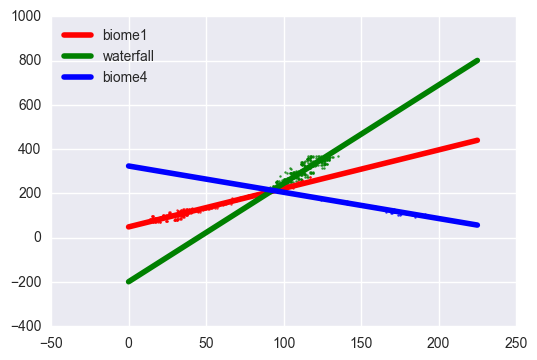

In [247]:
xs = np.linspace(0,225)

lines = [[], [], []]

for x in xs:
    for i, l in enumerate(params['mu']):
        y = l[1] + l[0] * x
        
#         if (((x >= water_path.centroid[0]-5) and (x <= s_b[i][1] + 20)) or 
#             ((x < water_path.centroid[0]+5) and (x > s_b[i][1] - 10) )):
            
        lines[i].append([x,y])

colors = ['r', 'g', 'b']
selection = np.argmax(params['T'], axis=1)

lines = [np.array(l) for l in lines]


for i in range(3):
    plt.scatter(params['X'][:,0][selection == i], params['y'][selection == i], c = colors[i], lw=0, s=3, alpha=0.8)

    plt.plot(lines[i][:,0], lines[i][:,1], c = colors[i], lw=4, label=s_b[i][0])

plt.legend(loc='best')
plt.show()

# Using a different coordinate system

Due to the radial nature of the water flows. What happens if we describe the system as purely a centroid surrounded by flows that are described by the angle that they make away from that centroid?

In [248]:
x_coord

array([ 14,  14,  15,  15,  15,  15,  16,  16,  16,  16,  16,  16,  16,
        16,  17,  17,  17,  17,  17,  17,  18,  18,  18,  18,  19,  19,
        19,  19,  19,  20,  20,  20,  20,  21,  21,  22,  22,  22,  22,
        22,  22,  22,  23,  23,  23,  23,  24,  24,  24,  25,  25,  25,
        26,  26,  26,  26,  26,  27,  27,  27,  28,  29,  29,  30,  30,
        30,  30,  30,  30,  30,  30,  31,  31,  31,  31,  31,  31,  31,
        31,  31,  31,  32,  32,  32,  32,  32,  32,  32,  32,  33,  33,
        33,  33,  34,  34,  34,  34,  34,  34,  35,  35,  35,  35,  35,
        35,  35,  35,  36,  36,  36,  36,  36,  36,  37,  37,  37,  37,
        37,  37,  37,  38,  38,  38,  38,  38,  38,  38,  38,  39,  39,
        39,  39,  39,  39,  39,  40,  40,  40,  40,  40,  40,  40,  41,
        41,  42,  42,  43,  44,  44,  45,  45,  45,  46,  46,  48,  48,
        49,  49,  50,  50,  51,  51,  51,  52,  52,  52,  53,  53,  54,
        54,  54,  54,  54,  54,  55,  55,  55,  56,  56,  57,  5

In [249]:
def convert_XY_to_radians(X, Y, x1, y1):
    deltaX = (X - x1).astype(np.float32)
    deltaY = (Y - y1).astype(np.float32)
    deltaX[deltaX==0] = 1e-15
    angles = np.arctan(deltaY/deltaX)
    angles[deltaX < 0] = angles[deltaX < 0] + np.pi
    return angles

def convert_theta_centroid_to_line(distances, theta, centroid):
    x = distances * np.cos(theta) + centroid[0]
    y = distances * np.sin(theta) + centroid[1]
    return (x,y)

def find_x_y(m1,m2,c1,c2):
    x = (c2-c1)/(m1-m2)
    y = m1 * x + c1
    return [x, y]

def straight_line(m,c,xs):
    return m*xs + c

In [250]:
K = 3
centroid = (200, 240)
thetas = [0,-1,1]

In [375]:
def get_thetas_and_centroid(x, y, mu, Sigma, K):
    angles = convert_XY_to_radians(x, y, mu[0], mu[1])
    
    k_means = sk.cluster.KMeans(n_clusters=K)
    clusters = k_means.fit_predict(angles.reshape(-1,1))

    thetas = np.array([np.median(angles[clusters == c]) for c in range(K)])
    standard_deviations = [np.std(angles[clusters == c]) for c in range(K)]

    # re-assign points to lines based on euclidean distance
    ms = []
    cs = []
    for i in range(K):
        l_r = linear_model.LinearRegression()
        l_r.fit(x[clusters == i].reshape(-1,1), y[clusters == i])
        c = l_r.intercept_
        m = l_r.coef_[0]
        ms.append(m)
        cs.append(c)

    ms = np.array(ms)
    cs = np.array(cs)
    
    x_y_samples = np.zeros((int(factorial(K)), 2))
    N = len(x_y_samples)
    for i, (l1, l2) in enumerate(itertools.permutations(range(K),2)):

        x_ = (cs[l1] - cs[l2])/(ms[l2] - ms[l1])
        y_ = ((ms[l1]*x_) + cs[l1])
        x_y_samples[i] = x_,y_

    mu_sample = np.mean(x_y_samples, axis=0)
    S_sample = np.eye(2) * np.var(x_y_samples, axis=0)
    
    # use a Gibbs sampled Bayesian update to estimate new posterior of 
    S0_minus1 = np.linalg.pinv(Sigma)
    SS_minus1 = np.linalg.pinv(S_sample)

    mu_posterior = np.linalg.pinv(S0_minus1 + N * SS_minus1).dot(S0_minus1.dot(mu) + N * SS_minus1.dot(mu_sample))
    Sigma_posterior = np.linalg.pinv(S0_minus1 + N * SS_minus1)
    
#     angles = convert_XY_to_radians(x, y, mu_posterior[0], mu_posterior[1])
#     k_means = sk.cluster.KMeans(n_clusters=K)
#     clusters = k_means.fit_predict(angles.reshape(-1,1))
#     thetas = np.array([np.mean(angles[clusters == c]) for c in range(K)])
#     standard_deviations = [np.std(angles[clusters == c]) for c in range(K)]
    
    return mu_posterior, Sigma_posterior, thetas, clusters, standard_deviations

In [376]:
def iterate_to_get_thetas_and_mu(mu_prior, sigma_prior, K):
    sd = np.ones(K)
    iteration = 0
    diff = 1e10
    while diff > 1e-3:
        mu_prior, sigma_prior, thetas, clusters, sd_n = get_thetas_and_centroid(x_coord, y_coord, mu_prior, sigma_prior, K)
        diff = np.abs(np.subtract(sd_n, sd)).sum()
        sd = sd_n
        iteration += 1
        if iteration >= 25:
            break
    return mu_prior, sigma_prior, thetas, clusters, sd_n

In [377]:
mu_prior = np.array([200,150])
sigma_prior = np.array([[200,0], [0,200]])
K = 3
mu, sigma, thetas, clusters, sd_n = iterate_to_get_thetas_and_mu(mu_prior, sigma_prior, K)

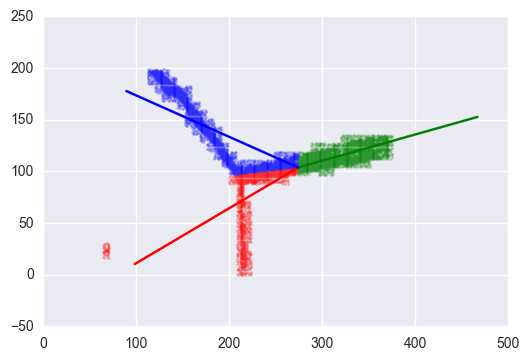

In [378]:
colors = ['r', 'g', 'b']
for i in range(3):
    plt.scatter(x_coord[clusters==i], y_coord[clusters==i], c=colors[i], lw=0, s=3, alpha=0.3)
    xs, ys = convert_theta_centroid_to_line(np.arange(200), thetas[i], mu)
    plt.plot(xs, ys, c=colors[i])

# plt.legend(loc='best')
plt.show()

In [379]:
# now using the inferred centroid and theta value as starting parameters. We can run this frame by frame
files = os.listdir("./frames")

In [380]:
next_file = cycle(files)
file = next(next_file) # get rid of the annoying first one

In [381]:
import time
import pylab as pl
from IPython import display

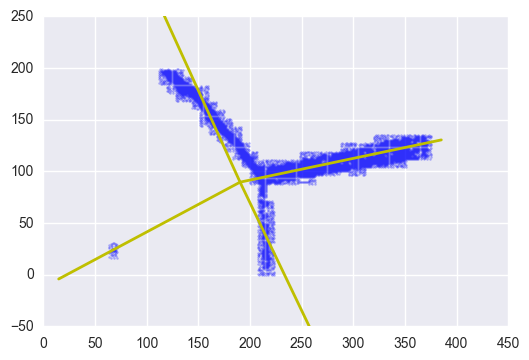

In [385]:
# file = next(next_file)
# image_arr = load_image("./frames/" + file)
K = 3
iteration = 0

mu_prior = np.array([50,50])
sigma_prior = np.array([[2000,0], [0,2000]])
sd = [1,1,1]

delta = 1
x = np.arange(0, 450, delta)
y = np.arange(-50, 250, delta)
X, Y = np.meshgrid(x, y)

for file in files:
    if not 'jpg' in file:
        continue
        
    image_arr = load_image("./frames/" + file)
    
    x_coord = []
    y_coord = []

    for i,row in enumerate(image_arr):
        for j, col in enumerate(row):
            if (col > 0):
                x_coord.append(j)
                y_coord.append(i)

    x_coord = np.array(x_coord)
    y_coord = np.array(y_coord)

    mu_prior, sigma_prior, thetas, clusters, sd = iterate_to_get_thetas_and_mu(mu_prior, sigma_prior, K)
    
    colors = ['b' for i in range(10)]#['y', 'g', 'b', 'r']
    colors2 = ['y' for i in range(10)]#['y', 'g', 'b', 'r']
    
    for i in range(K):
        pl.scatter(x_coord[clusters==i], y_coord[clusters==i], c=colors[i], lw=0, s=3, alpha=0.3)
        xs, ys = convert_theta_centroid_to_line(np.arange(200), thetas[i], mu_prior)
        pl.plot(xs, ys, c=colors2[i], lw=2)

    Z = mlab.bivariate_normal(X, Y, sigmax=sigma_prior[0][0], sigmay=sigma_prior[1][1], mux=mu_prior[0], muy=mu_prior[1])
    if np.sum(Z) > 1e-5:
        pl.contour(X, Y, Z)
    pl.xlim([0,450])
    pl.ylim([-50,250])

    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)
    pl.clf()
    
    iteration += 1
    
    if (np.max(sd) > 0.35):
        K += 1
    else:
        K -= 1
        
    if K < 3:
        K = 3

In [268]:
def extract_boundary(original,hsv_image, lower, upper, flag):
    # need end points of the boundary too
    mask = cv2.inRange(hsv_image, lower, upper)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(original,original,mask= mask)
    #boundaries in gray scale
    gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    # Otsu's thresholding and gaussian filtering  to make the logs white and the background black for better detection
    ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #logs will be white in th3
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if(flag==1):
        black, extLeft, extRight, cx,cy = find_contour(th3,original)
        return black,extLeft,extRight,cx,cy
    return th3   

#just identify water flow path for drawing graphs   
def detect_water(min_video_frame):
    hsv = cv2.cvtColor(min_video_frame, cv2.COLOR_BGR2HSV)
    # define range of green/yellow color in HSV
    lower_green = np.array([29,86,6])
    upper_green = np.array([64,255,255])
    th3 = extract_boundary(min_video_frame,hsv,lower_green, upper_green,0)    
    store = th3
    # morphing to get the skeletal structure/ medial line of the water flow    
    size = np.size(th3)    
    skel = np.zeros(th3.shape,np.uint8)    
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
 
    while(not done):
        eroded = cv2.erode(th3,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(th3,temp)
        skel = cv2.bitwise_or(skel,temp)
        th3 = eroded.copy()
 
        zeros = size - cv2.countNonZero(th3)
        if zeros==size:
            done = True
    return store,skel

In [ ]:
cap = cv2.VideoCapture('./0-Section_One-16-21-27-528.mov')
count = 0
while cap.isOpened():
    ret,frame = cap.read()

    if ret!=True:
        store, skel = detect_water(frame[864:1080,0:384])
#         cv2.imshow('window-name', store)
        cv2.imwrite("frames/frame%d.jpg" % count, store)
        count = count + 1
        
    else:
        # The next frame is not ready, so we try to read it again
        cap.set(1, count-1)
        # It is better to wait for a while for the next frame to be ready
        cv2.waitKey(1000)

    if cv2.waitKey(10) == 27:
        break
    if cap.get(1) == cap.get(7):
        # If the number of captured frames is equal to the total number of frames,
        # we stop
        break
        
cap.release()
cap.destroyAllWindows()